In [1]:
from load_cifar_10 import *
import numpy as np

In [2]:
# Load Data
cifar_10_dir = 'cifar-10-batches-py'

train_data, train_filenames, train_labels, test_data, test_filenames, test_labels, label_names = \
load_cifar_10_data(cifar_10_dir)

def Processing_data(train, test):
    #change dtype
    train = np.array(train, dtype=np.float64)
    test = np.array(test, dtype=np.float64)
    
    #Reshaping
    train = np.reshape(train, (train.shape[0], -1))
    test = np.reshape(test, (test.shape[0], -1))
    
    #Normalizing
    mean_image = np.mean(train, axis = 0)
    
    #print(train.dtype)
    train -= mean_image
    test -= mean_image
    
    return train, test

In [3]:
train_data, test_data = Processing_data(train_data, test_data)

In [4]:
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(50000, 3072)
(50000,)
(10000, 3072)
(10000,)


In [5]:
# train, test 각각 5000, 1000개만 뽑기
train_data = train_data[:5000]
train_labels = train_labels[:5000]
test_data = test_data[:1000]
test_labels = test_labels[:1000]

In [6]:
# Hyperparameters
input_size = 32 * 32 * 3
hidden_size = 50
output_size = 10
epoch_size = 1500
batch_size = 128
learning_rate = 5e-6
N = train_data.shape[0]
M = test_data.shape[0] # 새롭게 추가

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## 1. General Model

In [8]:
####################
### General Model 
###################
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # an affine operation : y = Wx + b
        self.fc1 = nn.Linear(input_size, hidden_size) # input, output
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()
print(net)

Net(
  (fc1): Linear(in_features=3072, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [9]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate)

In [10]:
from tqdm import tqdm
history = {'val_acc': [],'val_loss': [], 'train_acc':[], 'train_loss':[]} #기록해서 그림 그리자!

# TRAIN
# epoch size만큼 iteration
for i in tqdm(range(epoch_size)):
    correct = 0
    total = 0
    running_loss = 0
    ### 수정
    net.train()
    for j in range(N//batch_size):
        batch_mask = np.random.choice(N, batch_size) #이번 배치에서 쓸 데이터들 인덱스 추출
        x_batch = torch.FloatTensor(train_data[batch_mask])
        t_batch = torch.LongTensor(train_labels[batch_mask])
        
        # Gradient buffer를 0으로 초기화
        optimizer.zero_grad()
        
        # Forward
        outputs = net(x_batch)
        # Backward
        loss = criterion(outputs, t_batch)
        loss.backward()
        # Update the weights
        optimizer.step()
        
        # Statistics
        _, predicted = torch.max(outputs.data, 1)
        total += t_batch.size(0)
        correct += (predicted == t_batch).sum().item()
        running_loss += loss.item()
        
    acc = 100*correct/total    
    history['train_loss'].append(running_loss / 5000)
    history['train_acc'].append(acc)
    
    if i % 100 == 99: # print every 100 epochs 

        print('[%d] loss: %.3f acc: %.3f ' %
              (i + 1, running_loss, acc))
        print('Accuracy of the network on the 50000 train images: %d %%' %  acc)
        running_loss = 0.0

    # TEST
    correct = 0
    total = 0
    val_loss = 0
    ### 수정
    net.eval()
    with torch.no_grad():
        for k in range(M//batch_size):
            batch_mask = np.random.choice(M, batch_size) #이번 배치에서 쓸 데이터들 인덱스 추출
            x_batch = torch.FloatTensor(test_data[batch_mask])
            t_batch = torch.LongTensor(test_labels[batch_mask])
            
             # Forward
            outputs = net(x_batch)

            # loss
            loss = criterion(outputs, t_batch)
                        
            # Statistics
            _, predicted = torch.max(outputs.data, 1)
            total += t_batch.size(0)
            correct += (predicted == t_batch).sum().item()
            val_loss += loss.item()
        
        #accuracy와 loss를 기록해둡시다.
        acc = 100*correct/total
        history["val_acc"].append(acc)
        history["val_loss"].append(val_loss / 1000)
    
        if i % 100 == 99: # print every 100 epochs
            print('[%d] loss: %.3f acc: %.3f ' %
                  (i + 1, val_loss, acc))
            print('Accuracy of the network on the 10000 test images: %d %%' % acc)
            val_loss = 0.0
            
print("")

  7%|█████▎                                                                          | 99/1500 [01:39<21:46,  1.07it/s]

[100] loss: 151.219 acc: 36.038 
Accuracy of the network on the 50000 train images: 36 %
[100] loss: 42.043 acc: 29.353 
Accuracy of the network on the 10000 test images: 29 %


 13%|██████████▍                                                                    | 199/1500 [03:15<19:50,  1.09it/s]

[200] loss: 91.323 acc: 47.636 
Accuracy of the network on the 50000 train images: 47 %
[200] loss: 37.750 acc: 27.567 
Accuracy of the network on the 10000 test images: 27 %


 20%|███████████████▋                                                               | 299/1500 [04:50<18:15,  1.10it/s]

[300] loss: 67.873 acc: 56.010 
Accuracy of the network on the 50000 train images: 56 %
[300] loss: 34.947 acc: 29.576 
Accuracy of the network on the 10000 test images: 29 %


 27%|█████████████████████                                                          | 399/1500 [06:26<16:47,  1.09it/s]

[400] loss: 52.024 acc: 63.702 
Accuracy of the network on the 50000 train images: 63 %
[400] loss: 33.277 acc: 27.790 
Accuracy of the network on the 10000 test images: 27 %


 33%|██████████████████████████▎                                                    | 499/1500 [08:04<15:05,  1.11it/s]

[500] loss: 42.110 acc: 69.111 
Accuracy of the network on the 50000 train images: 69 %
[500] loss: 32.568 acc: 29.018 
Accuracy of the network on the 10000 test images: 29 %


 40%|███████████████████████████████▌                                               | 599/1500 [09:44<13:36,  1.10it/s]

[600] loss: 34.872 acc: 75.321 
Accuracy of the network on the 50000 train images: 75 %
[600] loss: 32.178 acc: 29.576 
Accuracy of the network on the 10000 test images: 29 %


 47%|████████████████████████████████████▊                                          | 699/1500 [11:21<12:04,  1.10it/s]

[700] loss: 29.383 acc: 78.926 
Accuracy of the network on the 50000 train images: 78 %
[700] loss: 32.276 acc: 28.795 
Accuracy of the network on the 10000 test images: 28 %


 53%|██████████████████████████████████████████                                     | 799/1500 [12:58<10:55,  1.07it/s]

[800] loss: 25.598 acc: 82.853 
Accuracy of the network on the 50000 train images: 82 %
[800] loss: 33.781 acc: 28.348 
Accuracy of the network on the 10000 test images: 28 %


 60%|███████████████████████████████████████████████▎                               | 899/1500 [14:31<09:11,  1.09it/s]

[900] loss: 21.625 acc: 85.437 
Accuracy of the network on the 50000 train images: 85 %
[900] loss: 32.547 acc: 28.571 
Accuracy of the network on the 10000 test images: 28 %


 67%|████████████████████████████████████████████████████▌                          | 999/1500 [16:03<08:18,  1.00it/s]

[1000] loss: 20.265 acc: 87.360 
Accuracy of the network on the 50000 train images: 87 %
[1000] loss: 29.195 acc: 33.705 
Accuracy of the network on the 10000 test images: 33 %


 73%|█████████████████████████████████████████████████████████▏                    | 1099/1500 [17:38<06:13,  1.07it/s]

[1100] loss: 17.474 acc: 90.044 
Accuracy of the network on the 50000 train images: 90 %
[1100] loss: 30.048 acc: 31.920 
Accuracy of the network on the 10000 test images: 31 %


 80%|██████████████████████████████████████████████████████████████▎               | 1199/1500 [19:11<04:36,  1.09it/s]

[1200] loss: 15.154 acc: 91.687 
Accuracy of the network on the 50000 train images: 91 %
[1200] loss: 31.900 acc: 30.357 
Accuracy of the network on the 10000 test images: 30 %


 87%|███████████████████████████████████████████████████████████████████▌          | 1299/1500 [20:42<03:02,  1.10it/s]

[1300] loss: 14.021 acc: 93.269 
Accuracy of the network on the 50000 train images: 93 %
[1300] loss: 31.755 acc: 30.692 
Accuracy of the network on the 10000 test images: 30 %


 93%|████████████████████████████████████████████████████████████████████████▋     | 1399/1500 [22:14<01:33,  1.09it/s]

[1400] loss: 12.980 acc: 93.790 
Accuracy of the network on the 50000 train images: 93 %
[1400] loss: 31.072 acc: 29.688 
Accuracy of the network on the 10000 test images: 29 %


100%|█████████████████████████████████████████████████████████████████████████████▉| 1499/1500 [23:47<00:00,  1.08it/s]

[1500] loss: 10.731 acc: 95.893 
Accuracy of the network on the 50000 train images: 95 %
[1500] loss: 31.682 acc: 33.147 
Accuracy of the network on the 10000 test images: 33 %


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [23:48<00:00,  1.07it/s]


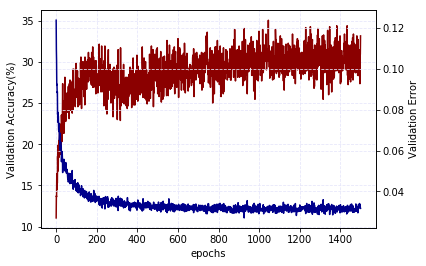

In [11]:
fig = plt.figure()
ax_acc = fig.add_subplot(111)

ax_acc.plot(range(epoch_size), history['val_acc'], label='정확도(%)', color='darkred')
plt.xlabel('epochs')
plt.ylabel('Validation Accuracy(%)')
ax_acc.grid(linestyle='--', color='lavender')
ax_loss = ax_acc.twinx()
ax_loss.plot(range(epoch_size), history['val_loss'], label='오차', color='darkblue')
plt.ylabel('Validation Error')
ax_loss.yaxis.tick_right()
ax_loss.grid(linestyle='--', color='lavender')

# 그래프 표시
plt.show()

In [12]:
print('Test accuracy: %.2f%%' % history['val_acc'][-1])
print('Test loss: %.2f' % history['val_loss'][-1])

Test accuracy: 33.15%
Test loss: 0.03


## 2. Batch Norm Model

In [13]:
################################
### Batch Normalization Model 
################################

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # an affine operation : y = Wx + b
        ### Hidden layer
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc1.bn = nn.BatchNorm1d(hidden_size) # Batch Normalization
 
        ### Output layer
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        x = self.fc1.bn(x) # Batch Normalization
        x = F.relu(x)
        
        x = self.fc2(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()
print(net)

Net(
  (fc1): Linear(
    in_features=3072, out_features=50, bias=True
    (bn): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [14]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate)

In [15]:
from tqdm import tqdm
history = {'val_acc': [],'val_loss': [], 'train_acc':[], 'train_loss':[]} #기록해서 그림 그리자!

# TRAIN
# epoch size만큼 iteration
for i in tqdm(range(epoch_size)):
    correct = 0
    total = 0
    running_loss = 0
    ### 수정
    net.train()
    for j in range(N//batch_size):
        batch_mask = np.random.choice(N, batch_size) #이번 배치에서 쓸 데이터들 인덱스 추출
        x_batch = torch.FloatTensor(train_data[batch_mask])
        t_batch = torch.LongTensor(train_labels[batch_mask])
        
        # Gradient buffer를 0으로 초기화
        optimizer.zero_grad()
        
        # Forward
        outputs = net(x_batch)
        # Backward
        loss = criterion(outputs, t_batch)
        loss.backward()
        # Update the weights
        optimizer.step()
        
        # Statistics
        _, predicted = torch.max(outputs.data, 1)
        total += t_batch.size(0)
        correct += (predicted == t_batch).sum().item()
        running_loss += loss.item()
        
    acc = 100*correct/total    
    history['train_loss'].append(running_loss / 5000)
    history['train_acc'].append(acc)
    
    if i % 100 == 99: # print every 100 epochs 

        print('[%d] loss: %.3f acc: %.3f ' %
              (i + 1, running_loss, acc))
        print('Accuracy of the network on the 50000 train images: %d %%' %  acc)
        running_loss = 0.0

    # TEST
    correct = 0
    total = 0
    val_loss = 0
    ### 수정
    net.eval()
    with torch.no_grad():
        for k in range(M//batch_size):
            batch_mask = np.random.choice(M, batch_size) #이번 배치에서 쓸 데이터들 인덱스 추출
            x_batch = torch.FloatTensor(test_data[batch_mask])
            t_batch = torch.LongTensor(test_labels[batch_mask])
            
             # Forward
            outputs = net(x_batch)

            # loss
            loss = criterion(outputs, t_batch)
                        
            # Statistics
            _, predicted = torch.max(outputs.data, 1)
            total += t_batch.size(0)
            correct += (predicted == t_batch).sum().item()
            val_loss += loss.item()
        
        #accuracy와 loss를 기록해둡시다.
        acc = 100*correct/total
        history["val_acc"].append(acc)
        history["val_loss"].append(val_loss / 1000)
    
        if i % 100 == 99: # print every 100 epochs
            print('[%d] loss: %.3f acc: %.3f ' %
                  (i + 1, val_loss, acc))
            print('Accuracy of the network on the 10000 test images: %d %%' % acc)
            val_loss = 0.0
            
print("")

  7%|█████▎                                                                          | 99/1500 [01:40<24:36,  1.05s/it]

[100] loss: 89.052 acc: 14.583 
Accuracy of the network on the 50000 train images: 14 %
[100] loss: 16.011 acc: 13.281 
Accuracy of the network on the 10000 test images: 13 %


 13%|██████████▍                                                                    | 199/1500 [03:36<21:31,  1.01it/s]

[200] loss: 88.297 acc: 16.847 
Accuracy of the network on the 50000 train images: 16 %
[200] loss: 15.907 acc: 18.192 
Accuracy of the network on the 10000 test images: 18 %


 20%|███████████████▋                                                               | 299/1500 [05:33<19:51,  1.01it/s]

[300] loss: 87.736 acc: 18.490 
Accuracy of the network on the 50000 train images: 18 %
[300] loss: 15.746 acc: 16.518 
Accuracy of the network on the 10000 test images: 16 %


 27%|█████████████████████                                                          | 399/1500 [07:14<18:10,  1.01it/s]

[400] loss: 87.271 acc: 18.109 
Accuracy of the network on the 50000 train images: 18 %
[400] loss: 15.714 acc: 17.746 
Accuracy of the network on the 10000 test images: 17 %


 33%|██████████████████████████▎                                                    | 499/1500 [08:53<16:21,  1.02it/s]

[500] loss: 86.877 acc: 19.772 
Accuracy of the network on the 50000 train images: 19 %
[500] loss: 15.654 acc: 16.518 
Accuracy of the network on the 10000 test images: 16 %


 40%|███████████████████████████████▌                                               | 599/1500 [10:41<14:59,  1.00it/s]

[600] loss: 86.572 acc: 20.813 
Accuracy of the network on the 50000 train images: 20 %
[600] loss: 15.664 acc: 18.304 
Accuracy of the network on the 10000 test images: 18 %


 47%|████████████████████████████████████▊                                          | 699/1500 [12:29<13:16,  1.01it/s]

[700] loss: 86.522 acc: 20.773 
Accuracy of the network on the 50000 train images: 20 %
[700] loss: 15.546 acc: 16.853 
Accuracy of the network on the 10000 test images: 16 %


 53%|██████████████████████████████████████████                                     | 799/1500 [14:38<13:20,  1.14s/it]

[800] loss: 86.161 acc: 20.974 
Accuracy of the network on the 50000 train images: 20 %
[800] loss: 15.552 acc: 17.076 
Accuracy of the network on the 10000 test images: 17 %


 60%|███████████████████████████████████████████████▎                               | 899/1500 [16:27<10:14,  1.02s/it]

[900] loss: 85.878 acc: 21.735 
Accuracy of the network on the 50000 train images: 21 %
[900] loss: 15.599 acc: 15.737 
Accuracy of the network on the 10000 test images: 15 %


 67%|████████████████████████████████████████████████████▌                          | 999/1500 [18:14<08:33,  1.03s/it]

[1000] loss: 85.614 acc: 22.676 
Accuracy of the network on the 50000 train images: 22 %
[1000] loss: 15.450 acc: 18.304 
Accuracy of the network on the 10000 test images: 18 %


 73%|█████████████████████████████████████████████████████████▏                    | 1099/1500 [20:01<07:02,  1.05s/it]

[1100] loss: 85.397 acc: 22.756 
Accuracy of the network on the 50000 train images: 22 %
[1100] loss: 15.330 acc: 23.103 
Accuracy of the network on the 10000 test images: 23 %


 80%|██████████████████████████████████████████████████████████████▎               | 1199/1500 [21:53<05:08,  1.03s/it]

[1200] loss: 85.066 acc: 23.738 
Accuracy of the network on the 50000 train images: 23 %
[1200] loss: 15.407 acc: 20.424 
Accuracy of the network on the 10000 test images: 20 %


 87%|███████████████████████████████████████████████████████████████████▌          | 1299/1500 [23:46<03:31,  1.05s/it]

[1300] loss: 84.600 acc: 25.100 
Accuracy of the network on the 50000 train images: 25 %
[1300] loss: 15.266 acc: 21.875 
Accuracy of the network on the 10000 test images: 21 %


 93%|████████████████████████████████████████████████████████████████████████▋     | 1399/1500 [25:33<01:43,  1.03s/it]

[1400] loss: 84.888 acc: 23.938 
Accuracy of the network on the 50000 train images: 23 %
[1400] loss: 15.310 acc: 20.424 
Accuracy of the network on the 10000 test images: 20 %


100%|█████████████████████████████████████████████████████████████████████████████▉| 1499/1500 [27:42<00:01,  1.07s/it]

[1500] loss: 84.577 acc: 24.299 
Accuracy of the network on the 50000 train images: 24 %
[1500] loss: 15.361 acc: 17.411 
Accuracy of the network on the 10000 test images: 17 %


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [27:43<00:00,  1.08s/it]


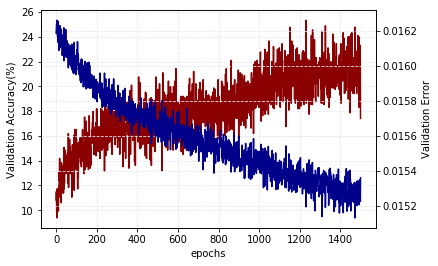

In [16]:
fig = plt.figure()
ax_acc = fig.add_subplot(111)

ax_acc.plot(range(epoch_size), history['val_acc'], label='정확도(%)', color='darkred')
plt.xlabel('epochs')
plt.ylabel('Validation Accuracy(%)')
ax_acc.grid(linestyle='--', color='lavender')
ax_loss = ax_acc.twinx()
ax_loss.plot(range(epoch_size), history['val_loss'], label='오차', color='darkblue')
plt.ylabel('Validation Error')
ax_loss.yaxis.tick_right()
ax_loss.grid(linestyle='--', color='lavender')

# 그래프 표시
plt.show()

In [17]:
print('Test accuracy: %.2f%%' % history['val_acc'][-1])
print('Test loss: %.2f' % history['val_loss'][-1])

Test accuracy: 17.41%
Test loss: 0.02


## 2-1. Batch Norm Model
#### - increased learning rate

In [24]:
# Hyperparameters
input_size = 32 * 32 * 3
hidden_size = 50
output_size = 10
epoch_size = 1500
batch_size = 128
learning_rate = 1e-4 ### 수정
N = train_data.shape[0]
M = test_data.shape[0] # 새롭게 추가

In [25]:
################################
### Batch Normalization Model 
################################

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # an affine operation : y = Wx + b
        ### Hidden layer
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc1.bn = nn.BatchNorm1d(hidden_size) # Batch Normalization
 
        ### Output layer
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        x = self.fc1.bn(x) # Batch Normalization
        x = F.relu(x)
        
        x = self.fc2(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()
print(net)

Net(
  (fc1): Linear(
    in_features=3072, out_features=50, bias=True
    (bn): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [26]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate)

In [27]:
from tqdm import tqdm
history = {'val_acc': [],'val_loss': [], 'train_acc':[], 'train_loss':[]} #기록해서 그림 그리자!

# TRAIN
# epoch size만큼 iteration
for i in tqdm(range(epoch_size)):
    correct = 0
    total = 0
    running_loss = 0
    ### 수정
    net.train()
    for j in range(N//batch_size):
        batch_mask = np.random.choice(N, batch_size) #이번 배치에서 쓸 데이터들 인덱스 추출
        x_batch = torch.FloatTensor(train_data[batch_mask])
        t_batch = torch.LongTensor(train_labels[batch_mask])
        
        # Gradient buffer를 0으로 초기화
        optimizer.zero_grad()
        
        # Forward
        outputs = net(x_batch)
        # Backward
        loss = criterion(outputs, t_batch)
        loss.backward()
        # Update the weights
        optimizer.step()
        
        # Statistics
        _, predicted = torch.max(outputs.data, 1)
        total += t_batch.size(0)
        correct += (predicted == t_batch).sum().item()
        running_loss += loss.item()
        
    acc = 100*correct/total    
    history['train_loss'].append(running_loss / 5000)
    history['train_acc'].append(acc)
    
    if i % 100 == 99: # print every 100 epochs 

        print('[%d] loss: %.3f acc: %.3f ' %
              (i + 1, running_loss, acc))
        print('Accuracy of the network on the 50000 train images: %d %%' %  acc)
        running_loss = 0.0

    # TEST
    correct = 0
    total = 0
    val_loss = 0
    ### 수정
    net.eval()
    with torch.no_grad():
        for k in range(M//batch_size):
            batch_mask = np.random.choice(M, batch_size) #이번 배치에서 쓸 데이터들 인덱스 추출
            x_batch = torch.FloatTensor(test_data[batch_mask])
            t_batch = torch.LongTensor(test_labels[batch_mask])
            
             # Forward
            outputs = net(x_batch)

            # loss
            loss = criterion(outputs, t_batch)
                        
            # Statistics
            _, predicted = torch.max(outputs.data, 1)
            total += t_batch.size(0)
            correct += (predicted == t_batch).sum().item()
            val_loss += loss.item()
        
        #accuracy와 loss를 기록해둡시다.
        acc = 100*correct/total
        history["val_acc"].append(acc)
        history["val_loss"].append(val_loss / 1000)
    
        if i % 100 == 99: # print every 100 epochs
            print('[%d] loss: %.3f acc: %.3f ' %
                  (i + 1, val_loss, acc))
            print('Accuracy of the network on the 10000 test images: %d %%' % acc)
            val_loss = 0.0
            
print("")

  7%|█▉                           | 99/1500 [01:47<25:47,  1.10s/it]

[100] loss: 83.462 acc: 27.384 
Accuracy of the network on the 50000 train images: 27 %
[100] loss: 15.037 acc: 27.232 
Accuracy of the network on the 10000 test images: 27 %


 13%|███▋                        | 199/1500 [03:36<23:52,  1.10s/it]

[200] loss: 80.950 acc: 33.794 
Accuracy of the network on the 50000 train images: 33 %
[200] loss: 14.726 acc: 30.580 
Accuracy of the network on the 10000 test images: 30 %


 20%|█████▌                      | 299/1500 [05:25<21:15,  1.06s/it]

[300] loss: 79.065 acc: 36.639 
Accuracy of the network on the 50000 train images: 36 %
[300] loss: 14.422 acc: 32.366 
Accuracy of the network on the 10000 test images: 32 %


 27%|███████▍                    | 399/1500 [07:16<20:06,  1.10s/it]

[400] loss: 77.633 acc: 37.079 
Accuracy of the network on the 50000 train images: 37 %
[400] loss: 14.206 acc: 34.375 
Accuracy of the network on the 10000 test images: 34 %


 33%|█████████▎                  | 499/1500 [09:06<18:10,  1.09s/it]

[500] loss: 75.841 acc: 41.006 
Accuracy of the network on the 50000 train images: 41 %
[500] loss: 13.941 acc: 35.826 
Accuracy of the network on the 10000 test images: 35 %


 40%|███████████▏                | 599/1500 [10:56<16:05,  1.07s/it]

[600] loss: 74.657 acc: 41.787 
Accuracy of the network on the 50000 train images: 41 %
[600] loss: 13.716 acc: 35.156 
Accuracy of the network on the 10000 test images: 35 %


 47%|█████████████               | 699/1500 [12:44<14:24,  1.08s/it]

[700] loss: 73.264 acc: 43.029 
Accuracy of the network on the 50000 train images: 43 %
[700] loss: 13.599 acc: 36.719 
Accuracy of the network on the 10000 test images: 36 %


 53%|██████████████▉             | 799/1500 [14:31<12:36,  1.08s/it]

[800] loss: 71.905 acc: 43.930 
Accuracy of the network on the 50000 train images: 43 %
[800] loss: 13.611 acc: 34.598 
Accuracy of the network on the 10000 test images: 34 %


 60%|████████████████▊           | 899/1500 [16:21<10:44,  1.07s/it]

[900] loss: 70.864 acc: 45.172 
Accuracy of the network on the 50000 train images: 45 %
[900] loss: 13.460 acc: 35.826 
Accuracy of the network on the 10000 test images: 35 %


 67%|██████████████████▋         | 999/1500 [18:11<09:08,  1.10s/it]

[1000] loss: 69.703 acc: 46.635 
Accuracy of the network on the 50000 train images: 46 %
[1000] loss: 13.411 acc: 31.808 
Accuracy of the network on the 10000 test images: 31 %


 73%|███████████████████▊       | 1099/1500 [20:01<07:49,  1.17s/it]

[1100] loss: 68.324 acc: 47.716 
Accuracy of the network on the 50000 train images: 47 %
[1100] loss: 13.284 acc: 34.710 
Accuracy of the network on the 10000 test images: 34 %


 80%|█████████████████████▌     | 1199/1500 [21:50<05:23,  1.08s/it]

[1200] loss: 66.948 acc: 49.519 
Accuracy of the network on the 50000 train images: 49 %
[1200] loss: 13.186 acc: 34.933 
Accuracy of the network on the 10000 test images: 34 %


 87%|███████████████████████▍   | 1299/1500 [23:39<03:44,  1.12s/it]

[1300] loss: 65.897 acc: 50.120 
Accuracy of the network on the 50000 train images: 50 %
[1300] loss: 12.991 acc: 37.165 
Accuracy of the network on the 10000 test images: 37 %


 93%|█████████████████████████▏ | 1399/1500 [25:30<01:51,  1.10s/it]

[1400] loss: 64.988 acc: 51.402 
Accuracy of the network on the 50000 train images: 51 %
[1400] loss: 12.779 acc: 35.045 
Accuracy of the network on the 10000 test images: 35 %


100%|██████████████████████████▉| 1499/1500 [27:19<00:01,  1.09s/it]

[1500] loss: 62.857 acc: 54.046 
Accuracy of the network on the 50000 train images: 54 %
[1500] loss: 12.887 acc: 37.165 
Accuracy of the network on the 10000 test images: 37 %


100%|███████████████████████████| 1500/1500 [27:20<00:00,  1.11s/it]


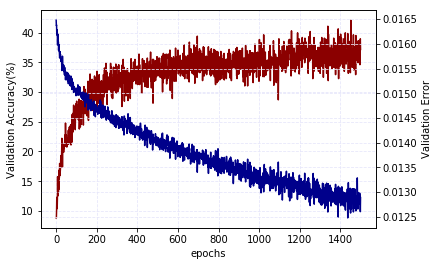

In [28]:
fig = plt.figure()
ax_acc = fig.add_subplot(111)

ax_acc.plot(range(epoch_size), history['val_acc'], label='정확도(%)', color='darkred')
plt.xlabel('epochs')
plt.ylabel('Validation Accuracy(%)')
ax_acc.grid(linestyle='--', color='lavender')
ax_loss = ax_acc.twinx()
ax_loss.plot(range(epoch_size), history['val_loss'], label='오차', color='darkblue')
plt.ylabel('Validation Error')
ax_loss.yaxis.tick_right()
ax_loss.grid(linestyle='--', color='lavender')

# 그래프 표시
plt.show()

In [29]:
print('Test accuracy: %.2f%%' % history['val_acc'][-1])
print('Test loss: %.2f' % history['val_loss'][-1])
# 위에서 learning rate를 일반 모델과 같게 했을 때에는 overfitting은 없어졌지만 오히려 underfitting되어 성능이 많이 떨어졌다.
# 그러나 learning rate를 증가시켰을 때 성능이 올랐음을 알 수 있다.

Test accuracy: 37.17%
Test loss: 0.01


## 3. Dropout Model

In [36]:
# Hyperparameters
dropout_prob = 0.5 # Dropout
input_size = 32 * 32 * 3
hidden_size = 50
output_size = 10
epoch_size = 1500
batch_size = 128
learning_rate = 5e-6
N = train_data.shape[0]
M = test_data.shape[0] # 새롭게 추가

In [37]:
#####################
### Dropout Model 
#####################

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # an affine operation : y = Wx + b
        ### Hidden layer
        self.fc1 = nn.Linear(input_size, hidden_size) 

        ### Output layer
        self.fc2 = nn.Linear(hidden_size, output_size)
 
    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, p=dropout_prob, training=self.training) # drop out
        
        x = self.fc2(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()
print(net)

Net(
  (fc1): Linear(in_features=3072, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [38]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate)

In [39]:
from tqdm import tqdm
history = {'val_acc': [],'val_loss': [], 'train_acc':[], 'train_loss':[]} #기록해서 그림 그리자!

# TRAIN
# epoch size만큼 iteration
for i in tqdm(range(epoch_size)):
    correct = 0
    total = 0
    running_loss = 0
    ### 수정
    net.train()
    for j in range(N//batch_size):
        batch_mask = np.random.choice(N, batch_size) #이번 배치에서 쓸 데이터들 인덱스 추출
        x_batch = torch.FloatTensor(train_data[batch_mask])
        t_batch = torch.LongTensor(train_labels[batch_mask])
        
        # Gradient buffer를 0으로 초기화
        optimizer.zero_grad()
        
        # Forward
        outputs = net(x_batch)
        # Backward
        loss = criterion(outputs, t_batch)
        loss.backward()
        # Update the weights
        optimizer.step()
        
        # Statistics
        _, predicted = torch.max(outputs.data, 1)
        total += t_batch.size(0)
        correct += (predicted == t_batch).sum().item()
        running_loss += loss.item()
        
    acc = 100*correct/total    
    history['train_loss'].append(running_loss / 5000)
    history['train_acc'].append(acc)
    
    if i % 100 == 99: # print every 100 epochs 

        print('[%d] loss: %.3f acc: %.3f ' %
              (i + 1, running_loss, acc))
        print('Accuracy of the network on the 50000 train images: %d %%' %  acc)
        running_loss = 0.0

    # TEST
    correct = 0
    total = 0
    val_loss = 0
    ### 수정
    net.eval()
    with torch.no_grad():
        for k in range(M//batch_size):
            batch_mask = np.random.choice(M, batch_size) #이번 배치에서 쓸 데이터들 인덱스 추출
            x_batch = torch.FloatTensor(test_data[batch_mask])
            t_batch = torch.LongTensor(test_labels[batch_mask])
            
             # Forward
            outputs = net(x_batch)

            # loss
            loss = criterion(outputs, t_batch)
                        
            # Statistics
            _, predicted = torch.max(outputs.data, 1)
            total += t_batch.size(0)
            correct += (predicted == t_batch).sum().item()
            val_loss += loss.item()
        
        #accuracy와 loss를 기록해둡시다.
        acc = 100*correct/total
        history["val_acc"].append(acc)
        history["val_loss"].append(val_loss / 1000)
    
        if i % 100 == 99: # print every 100 epochs
            print('[%d] loss: %.3f acc: %.3f ' %
                  (i + 1, val_loss, acc))
            print('Accuracy of the network on the 10000 test images: %d %%' % acc)
            val_loss = 0.0
            
print("")

  7%|█▉                           | 99/1500 [02:06<36:22,  1.56s/it]

[100] loss: 294.915 acc: 25.000 
Accuracy of the network on the 50000 train images: 25 %
[100] loss: 39.705 acc: 26.674 
Accuracy of the network on the 10000 test images: 26 %


 13%|███▋                        | 199/1500 [04:36<32:40,  1.51s/it]

[200] loss: 210.675 acc: 29.167 
Accuracy of the network on the 50000 train images: 29 %
[200] loss: 33.984 acc: 27.232 
Accuracy of the network on the 10000 test images: 27 %


 20%|█████▌                      | 299/1500 [07:04<35:14,  1.76s/it]

[300] loss: 172.758 acc: 31.470 
Accuracy of the network on the 50000 train images: 31 %
[300] loss: 31.498 acc: 28.906 
Accuracy of the network on the 10000 test images: 28 %


 27%|███████▍                    | 399/1500 [09:47<25:27,  1.39s/it]

[400] loss: 140.812 acc: 34.655 
Accuracy of the network on the 50000 train images: 34 %
[400] loss: 28.309 acc: 25.893 
Accuracy of the network on the 10000 test images: 25 %


 33%|█████████▎                  | 499/1500 [12:32<24:49,  1.49s/it]

[500] loss: 122.857 acc: 38.141 
Accuracy of the network on the 50000 train images: 38 %
[500] loss: 23.892 acc: 30.357 
Accuracy of the network on the 10000 test images: 30 %


 40%|███████████▏                | 599/1500 [15:14<26:10,  1.74s/it]

[600] loss: 111.008 acc: 38.421 
Accuracy of the network on the 50000 train images: 38 %
[600] loss: 24.172 acc: 31.362 
Accuracy of the network on the 10000 test images: 31 %


 47%|█████████████               | 699/1500 [18:05<22:26,  1.68s/it]

[700] loss: 100.280 acc: 41.126 
Accuracy of the network on the 50000 train images: 41 %
[700] loss: 24.646 acc: 29.911 
Accuracy of the network on the 10000 test images: 29 %


 53%|██████████████▉             | 799/1500 [21:01<19:33,  1.67s/it]

[800] loss: 95.981 acc: 41.346 
Accuracy of the network on the 50000 train images: 41 %
[800] loss: 22.089 acc: 31.473 
Accuracy of the network on the 10000 test images: 31 %


 60%|████████████████▊           | 899/1500 [24:02<18:51,  1.88s/it]

[900] loss: 84.331 acc: 43.129 
Accuracy of the network on the 50000 train images: 43 %
[900] loss: 22.436 acc: 29.576 
Accuracy of the network on the 10000 test images: 29 %


 67%|██████████████████▋         | 999/1500 [26:57<15:43,  1.88s/it]

[1000] loss: 79.231 acc: 46.114 
Accuracy of the network on the 50000 train images: 46 %
[1000] loss: 23.172 acc: 28.683 
Accuracy of the network on the 10000 test images: 28 %


 73%|███████████████████▊       | 1099/1500 [29:48<09:36,  1.44s/it]

[1100] loss: 74.196 acc: 47.416 
Accuracy of the network on the 50000 train images: 47 %
[1100] loss: 20.829 acc: 31.250 
Accuracy of the network on the 10000 test images: 31 %


 80%|█████████████████████▌     | 1199/1500 [32:28<07:15,  1.45s/it]

[1200] loss: 72.569 acc: 47.576 
Accuracy of the network on the 50000 train images: 47 %
[1200] loss: 22.429 acc: 31.027 
Accuracy of the network on the 10000 test images: 31 %


 87%|███████████████████████▍   | 1299/1500 [34:59<04:40,  1.39s/it]

[1300] loss: 69.280 acc: 49.018 
Accuracy of the network on the 50000 train images: 49 %
[1300] loss: 20.183 acc: 30.804 
Accuracy of the network on the 10000 test images: 30 %


 93%|█████████████████████████▏ | 1399/1500 [37:21<02:15,  1.34s/it]

[1400] loss: 65.233 acc: 49.760 
Accuracy of the network on the 50000 train images: 49 %
[1400] loss: 19.630 acc: 30.357 
Accuracy of the network on the 10000 test images: 30 %


100%|██████████████████████████▉| 1499/1500 [40:11<00:01,  1.57s/it]

[1500] loss: 59.768 acc: 52.344 
Accuracy of the network on the 50000 train images: 52 %
[1500] loss: 20.960 acc: 30.134 
Accuracy of the network on the 10000 test images: 30 %


100%|███████████████████████████| 1500/1500 [40:13<00:00,  1.52s/it]


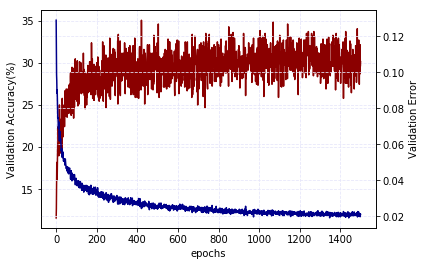

In [40]:
fig = plt.figure()
ax_acc = fig.add_subplot(111)

ax_acc.plot(range(epoch_size), history['val_acc'], label='정확도(%)', color='darkred')
plt.xlabel('epochs')
plt.ylabel('Validation Accuracy(%)')
ax_acc.grid(linestyle='--', color='lavender')
ax_loss = ax_acc.twinx()
ax_loss.plot(range(epoch_size), history['val_loss'], label='오차', color='darkblue')
plt.ylabel('Validation Error')
ax_loss.yaxis.tick_right()
ax_loss.grid(linestyle='--', color='lavender')

# 그래프 표시
plt.show()

In [41]:
print('Test accuracy: %.2f%%' % history['val_acc'][-1])
print('Test loss: %.2f' % history['val_loss'][-1])

Test accuracy: 30.13%
Test loss: 0.02
